# غرسة 🌿: Plant Disease Detection using Hue-based Feature Extraction and MLP
----

**1. Approach Overview**

In this project, we aim to detect plant infections by analyzing hue-based features extracted from leaf images. The process involves removing healthy green areas to isolate infected regions, then computing shape and color characteristics. These features are later fed into an MLP model for classification.
<div align="center">
  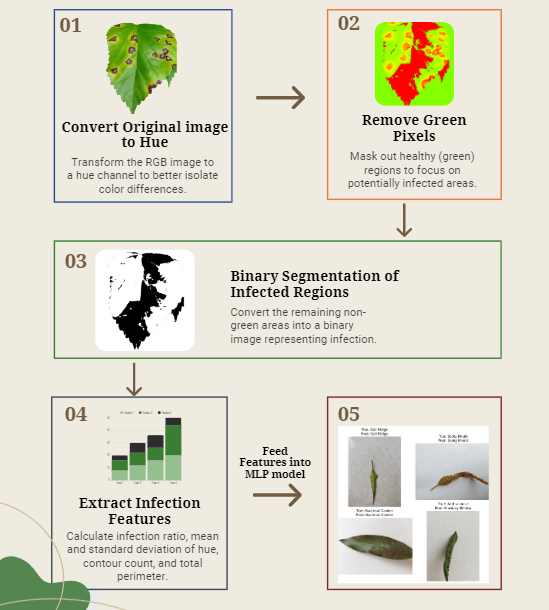
</div>

---

### **Image Preprocessing**
> **Objective:** Load the image and convert it to hue format  
> Convert RGB image to Hue using a custom `rgb_to_hue()` function.

---

###  **Masking Healthy Areas**
> **Objective:** Remove green pixels that represent healthy regions  
> Apply `mask_green_pixels()` to suppress green pixels (typically between hue values 0.25 to 0.45).

---

### **Binary Conversion**
> **Objective:** Convert the masked image to binary  
> Set infected areas to `1`, and healthy (green) areas to `0`.

---

### **Feature Extraction**
> **Objective:** Extract meaningful features for classification  
> - Infected Ratio  
> - Hue Mean & Std  
> - Contour count and total perimeter

---

### **MLP Classification**
> **Objective:** Use the extracted features as input to an MLP model  
> The model classifies the leaf condition based on the computed features.

---

### **Conclusion & Next Steps**
> The workflow successfully segments infected regions and extracts robust features.  
> The MLP model will now be trained and evaluated using these features.  
> Future steps may include expanding the dataset, testing other classifiers, and improving segmentation techniques.

---

# 0. Dependencies

In [8]:
!pip install roboflow
!pip install -U opendatasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


# 1. Importing Libraries

In [1]:
import os
import cv2
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendatasets
from roboflow import Roboflow
from google.colab import files
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import joblib

import warnings
warnings.filterwarnings('ignore')

# 2. Loading the Datasets

- **Orchid leaf dataset**

In [2]:
rf = Roboflow(api_key="3hwJ5It8G8YiFoiDLpPq")
# project = rf.workspace("bananalyse-vb145").project("leaf-disease-detection-4ksqw")
project = rf.workspace("hehe-ngdal").project("orchid-leaf-spots-blujx")
version = project.version(11)
dataset = version.download("YOLOv8")

loading Roboflow workspace...
loading Roboflow project...

Version export complete for YOLOv8 format



Extracting Dataset Version Zip to Orchid-leaf-spots-11 in YOLOv8:: 100%|██████████| 3808/3808 [00:00<00:00, 4818.00it/s]


In [3]:
with open('/content/Orchid-leaf-spots-11/data.yaml', 'r') as f:
    data = yaml.safe_load(f)
class_names = data['names']

base_path = '/content/Orchid-leaf-spots-11/train'
image_dir = os.path.join(base_path, '/content/Orchid-leaf-spots-11/train/images')
label_dir = os.path.join(base_path, '/content/Orchid-leaf-spots-11/train/labels')

data_list = []

for img_file in os.listdir(image_dir):
    if not img_file.lower().endswith(('.jpg', '.png', '.jpeg')):
        continue

    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, img_file.rsplit('.', 1)[0] + '.txt')

    if not os.path.exists(label_path):
        continue

    with open(label_path, 'r') as f:
        lines = f.readlines()

    if not lines:
        continue

    class_id = int(lines[0].split()[0])
    class_name = class_names[class_id]

    data_list.append({
        'image_path': img_path,
        'class_name': class_name
    })

df = pd.DataFrame(data_list)

df.head()

,image_path,class_name
0,/content/Orchid-leaf-spots-11/train/images/ima...,burn
1,/content/Orchid-leaf-spots-11/train/images/533...,rot
2,/content/Orchid-leaf-spots-11/train/images/60_...,rot
3,/content/Orchid-leaf-spots-11/train/images/6_j...,rot
4,/content/Orchid-leaf-spots-11/train/images/tai...,rot


In [4]:
df.shape

(1566, 2)

In [5]:
df['class_name'].value_counts()

,count
class_name,
rot,662
burn,477
spot,427


In [6]:
df = df[df['class_name'] != 'spot']

In [7]:
df['class_name'].value_counts()

,count
class_name,
rot,662
burn,477


In [8]:
df.to_csv('new_dataset.csv', index=False)

- **Mango leaf dataset**

In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"majdalotaibi","key":"8b788d2d31ab0efc12b7bbc5bf75bf5b"}'}

In [10]:
opendatasets.download('https://www.kaggle.com/datasets/warcoder/mango-leaf-disease-dataset',force=True )

Dataset URL: https://www.kaggle.com/datasets/warcoder/mango-leaf-disease-dataset


100%|██████████| 104M/104M [00:00<00:00, 1.24GB/s]

# 3. Reading the Datasets

**Load both datasets:**

In [11]:
dataset_dir = '/content/mango-leaf-disease-dataset/MangoLeafBD Dataset'
categories = os.listdir(dataset_dir)
image_paths, labels = [], []

for label, category in enumerate(categories):
    for image_name in os.listdir(os.path.join(dataset_dir, category)):
        image_paths.append(os.path.join(dataset_dir, category, image_name))
        labels.append(label)

df = pd.DataFrame({'filepath': image_paths, 'label': labels})
# df = df[~df['label'].isin([0,2, 3, 5])] # 79
df = df[~df['label'].isin([0,1,2, 3, 5])]


new_data = pd.read_csv('/content/new_dataset.csv')
new_data = new_data.rename(columns={'image_path': 'filepath', 'class_name': 'label_name'})


start_label = df['label'].max() + 1
label_mapping = {name: i + start_label for i, name in enumerate(new_data['label_name'].unique())}
new_data['label'] = new_data['label_name'].map(label_mapping)

combined_df = pd.concat([
    df[['filepath', 'label']],
    new_data[['filepath', 'label']]
], ignore_index=True)

# 4. Converting to Hue

In [15]:
def rgb_to_hue(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    r, g, b = cv2.split(image)
    num = 0.5 * ((r - g) + (r - b))
    den = np.sqrt((r - g) ** 2 + (r - b) * (g - b)) + 1e-6
    theta = np.arccos(num / den)
    h = np.where(b > g, 2 * np.pi - theta, theta) / (2 * np.pi)
    return h

# 5. Masking Green Pixels

In [16]:
def mask_green_pixels(hue_image):
    green_mask = (hue_image > 0.25) & (hue_image < 0.45)
    return np.where(green_mask, 0, hue_image)

# 6. Extracting Features

In [17]:
def extract_features(image_path):
    image = cv2.imread(image_path)
    if image is None: return None
    hue = rgb_to_hue(image)
    masked = mask_green_pixels(hue)
    binary = np.where(masked > 0, 1, 0).astype(np.uint8)

    infected_ratio = binary.sum() / binary.size
    infected_hues = hue[binary == 1]
    mean_hue = infected_hues.mean() if infected_hues.size else 0
    std_hue = infected_hues.std() if infected_hues.size else 0

    edges = cv2.Canny((binary * 255).astype(np.uint8), 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    perimeter = sum([cv2.arcLength(cnt, True) for cnt in contours])
    num_contours = len(contours)

    return [infected_ratio, perimeter, mean_hue, std_hue, num_contours]

**Example**

📄 Image: Hibiscus-leaf-spot-Flikr-Scot-Nelson-removebg-preview.png
🟢 Infected ratio: 0.7691
📏 Contour perimeter: 8678.09
🎨 Mean hue: 0.2295
🎨 Std hue: 0.0536
🔳 Number of contours: 248
--------------------------------------------------


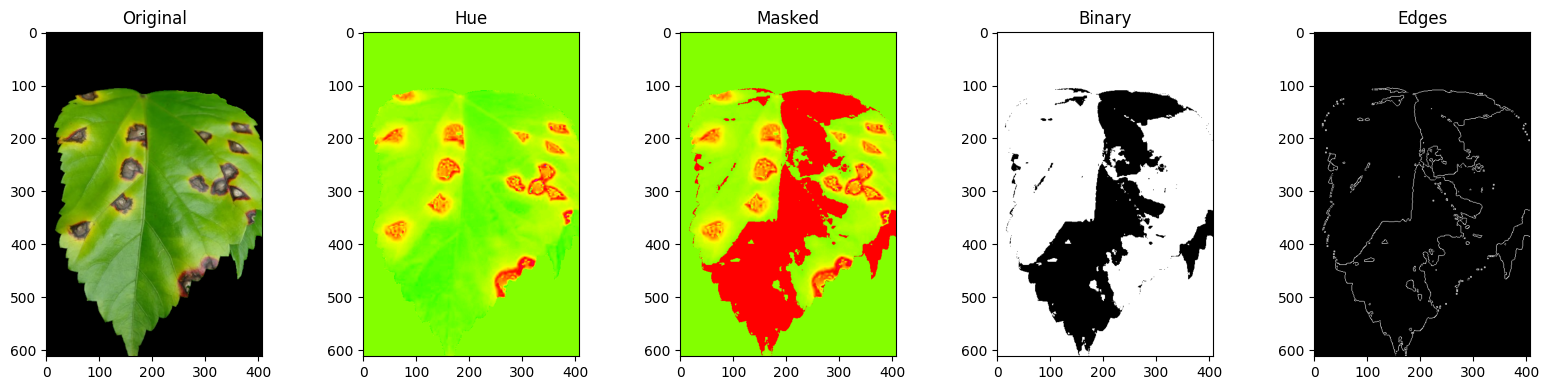

In [18]:
image_path = '/content/Hibiscus-leaf-spot-Flikr-Scot-Nelson-removebg-preview.png'
features = extract_features(image_path)

image = cv2.imread(image_path)
hue = rgb_to_hue(image)
masked = mask_green_pixels(hue)
binary = np.where(masked > 0, 1, 0).astype(np.uint8)
edges = cv2.Canny((binary * 255).astype(np.uint8), 100, 200)

if features:
    infected_ratio, perimeter, mean_hue, std_hue, num_contours = features

    print(f"📄 Image: {os.path.basename(image_path)}")
    print(f"🟢 Infected ratio: {infected_ratio:.4f}")
    print(f"📏 Contour perimeter: {perimeter:.2f}")
    print(f"🎨 Mean hue: {mean_hue:.4f}")
    print(f"🎨 Std hue: {std_hue:.4f}")
    print(f"🔳 Number of contours: {num_contours}")
    print("-" * 50)

    plt.figure(figsize=(16, 4))

    plt.subplot(1, 5, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original")

    plt.subplot(1, 5, 2)
    plt.imshow(hue, cmap='hsv')
    plt.title("Hue")

    plt.subplot(1, 5, 3)
    plt.imshow(masked, cmap='hsv')
    plt.title("Masked")

    plt.subplot(1, 5, 4)
    plt.imshow(binary, cmap='gray')
    plt.title("Binary")

    plt.subplot(1, 5, 5)
    plt.imshow(edges, cmap='gray')
    plt.title("Edges")
    plt.tight_layout()
    plt.show()
else:
    print("❌ Failed to extract features.")

Apply the feature extraction function on each image:

In [19]:
features, new_labels = [], []
for path, label in zip(combined_df['filepath'], combined_df['label']):
    result = extract_features(path)
    if result:
        features.append(result)
        new_labels.append(label)

X = np.array(features)
y = np.array(new_labels)

In [20]:
X.shape, y.shape

((2639, 5), (2639,))

In [21]:
X

array([[9.87747396e-01, 1.20426406e+03, 4.64550018e-01, 2.38867402e-01,
        6.60000000e+01],
       [9.96927083e-01, 4.00107645e+02, 4.24239129e-01, 2.90883511e-01,
        2.90000000e+01],
       [9.92708333e-01, 1.02634018e+03, 4.84386772e-01, 2.27560252e-01,
        7.30000000e+01],
       ...,
       [4.38356934e-01, 2.26721067e+04, 1.61250845e-01, 1.13627255e-01,
        8.96000000e+02],
       [8.97395020e-01, 3.51280467e+04, 2.03857958e-01, 1.17265858e-01,
        1.54600000e+03],
       [7.95324707e-01, 1.97562018e+04, 3.44892740e-01, 3.15600544e-01,
        6.85000000e+02]])

# 7. Data Splitting & Scaling

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8. Hyperparameter Tuning for MLP

In [ ]:
param_grid_mlp = {
    'hidden_layer_sizes': [
    # (150, 100, 50), (200, 150, 100), (100, 100, 100)
    # (100,), (100, 50), (200, 100, 50),
    # (128, 128), (64, 64, 64), (256, 128, 64)
    # (128, 128), (512, 256, 128), (128, 64), (64, 64, 64)
    (200, 150, 100)
],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.0001, 0.001,],
}

grid_search_mlp = GridSearchCV(
    MLPClassifier(
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=10,
        batch_size=32
    ),
    param_grid_mlp,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_mlp.fit(X_train_scaled, y_train)

# 9. Best Parameters and Evaluation

In [ ]:
print("--", grid_search_mlp.best_params_)
best_model = grid_search_mlp.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print(f"\nACC: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

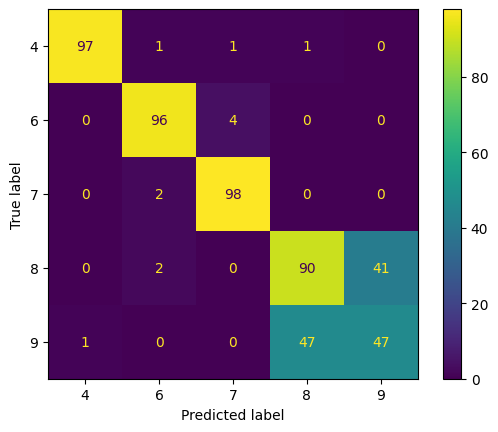

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = ConfusionMatrixDisplay.from_estimator(best_model, X_test_scaled, y_test)
plt.show()

# 10. Save the Model and Scaler

In [ ]:
joblib.dump(best_model, 'mlp_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# 11. Finally… Our MLP Model Is Ready to Show Off !🤖💪

In [ ]:
# Load the trained model and scaler
model = joblib.load('orchid_mlp_model.pkl')
scaler = joblib.load('/content/scaler.pkl')

# Define class names based on prediction values
class_names = {
    4: "Gall Midge",
    6: "Powdery Mildew",
    7: "Sooty Mould",
    8: "rot",
    9: "burn"
}

# Function to convert RGB to hue
def rgb_to_hue(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    r, g, b = cv2.split(image)
    num = 0.5 * ((r - g) + (r - b))
    den = np.sqrt((r - g)**2 + (r - b)*(g - b)) + 1e-6
    theta = np.arccos(num / den)
    h = np.where(b > g, 2 * np.pi - theta, theta) / (2 * np.pi)
    return h

# Function to mask green pixels in the hue image
def mask_green_pixels(hue_image):
    green_mask = (hue_image > 0.25) & (hue_image < 0.45)
    return np.where(green_mask, 0, hue_image)

# Function to extract features from an image
def extract_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    hue = rgb_to_hue(image)
    masked = mask_green_pixels(hue)
    binary = np.where(masked > 0, 1, 0).astype(np.uint8)

    infected_ratio = binary.sum() / binary.size
    infected_hues = hue[binary == 1]
    mean_hue = infected_hues.mean() if infected_hues.size > 0 else 0
    std_hue = infected_hues.std() if infected_hues.size > 0 else 0

    edges = cv2.Canny((binary * 255).astype(np.uint8), 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours)
    num_contours = len(contours)

    return [infected_ratio, perimeter, mean_hue, std_hue, num_contours]

# Upload an image and make predictions
uploaded = files.upload()
for filename in uploaded.keys():
    features = extract_features(filename)
    if features is not None:
        features_scaled = scaler.transform([features])
        prediction = model.predict(features_scaled)[0]
        class_label = class_names.get(prediction, "Unknown")

        print(f"\n🔍 Predicted result for '{filename}': {class_label}")

        image = cv2.imread(filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.title(f"Prediction: {class_label}", fontsize=14)
        plt.axis('off')
        plt.show()
    else:
        print(f"❌ Failed to process image '{filename}'")

Here are some of the predictions made by our model:

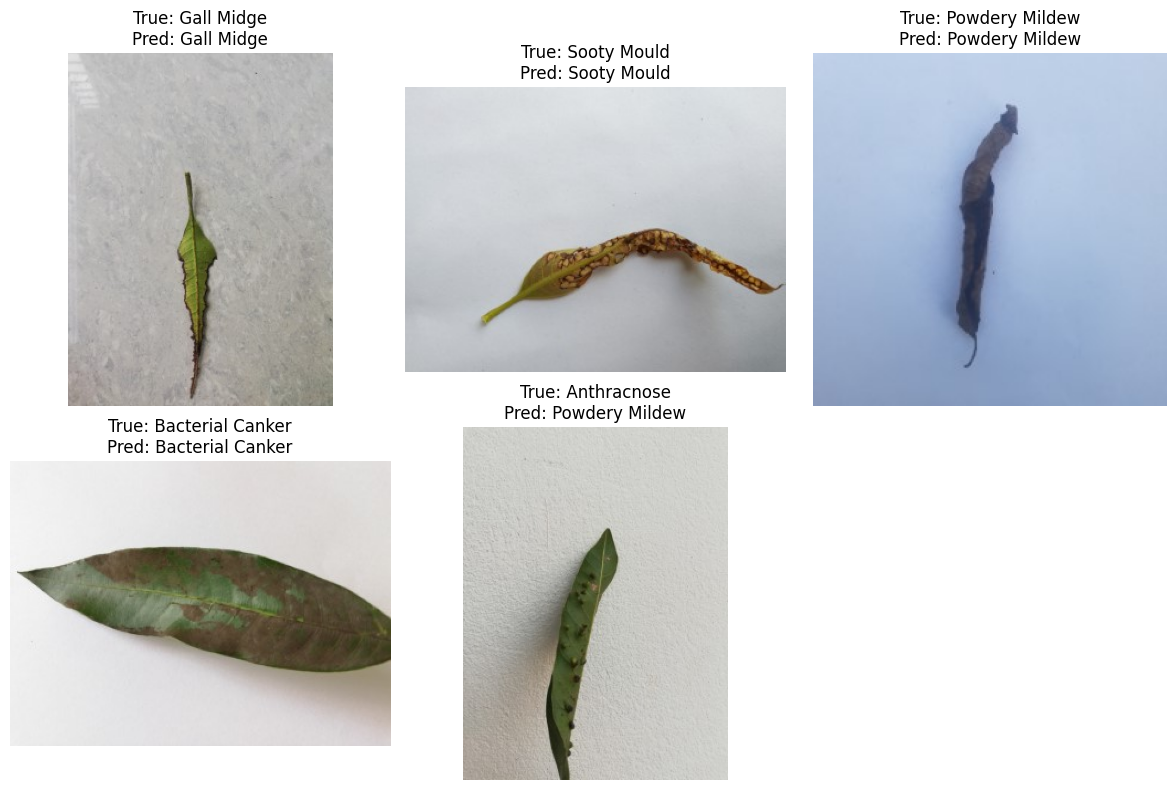